<a href="https://colab.research.google.com/github/m-pedram/kaggleCovid/blob/main/Covid_Final_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade --quiet
!pip install catboost --quiet
!pip install lightgbm --quiet
!pip install xgboost --quiet
!pip install hyperopt --quiet
!pip install mlxtend --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 6.7 MB/s eta 0:00:00


In [ ]:
# Import modules
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
%matplotlib inline
import matplotlib.ticker as ticker
import functools
from itertools import combinations
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.feature_selection import RFE

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from google.colab import files
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
# read data from Google Drive
# from google.colab import drive 
# drive.mount('/content/drive')

# data = pd.read_csv('https://raw.githubusercontent.com/m-pedram/kaggleCovid/main/Report03/rawData.csv')
data = pd.read_csv('https://raw.githubusercontent.com/m-pedram/kaggleCovid/main/Report03/TW2.csv')
filledData = data.query("PATIENT_VISIT_IDENTIFIER == 0").fillna(method='pad')
filledData = filledData.query("PATIENT_VISIT_IDENTIFIER == 0").fillna(method='backfill')
for patient_identifier in range(1,255):
  tempDf = data.query("PATIENT_VISIT_IDENTIFIER == @patient_identifier").fillna(method='pad')
  tempDf2 = tempDf.query("PATIENT_VISIT_IDENTIFIER == @patient_identifier").fillna(method='backfill')
  filledData = pd.concat([filledData, tempDf2])

pd.set_option('display.max_rows',300) # Set display rows to 300 
pd.set_option('display.max_columns',300) # Set Display columns to 300
filledData.head()
# imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# imp.fit(filledData)
# table = imp.transform(filledData)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MIN,BE_ARTERIAL_MIN,BE_VENOUS_MIN,BIC_ARTERIAL_MIN,BIC_VENOUS_MIN,BILLIRUBIN_MIN,BLAST_MIN,CALCIUM_MIN,CREATININ_MIN,FFA_MIN,GGT_MIN,GLUCOSE_MIN,HEMATOCRITE_MIN,HEMOGLOBIN_MIN,INR_MIN,LACTATE_MIN,LEUKOCYTES_MIN,LINFOCITOS_MIN,NEUTROPHILES_MIN,P02_ARTERIAL_MIN,P02_VENOUS_MIN,PC02_ARTERIAL_MIN,PC02_VENOUS_MIN,PCR_MIN,PH_ARTERIAL_MIN,PH_VENOUS_MIN,PLATELETS_MIN,POTASSIUM_MIN,SAT02_ARTERIAL_MIN,SAT02_VENOUS_MIN,SODIUM_MIN,TGO_MIN,TGP_MIN,TTPA_MIN,UREA_MIN,DIMER_MIN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU?Prediction
0,0,1,0.2,0,0,0,0,0,1,1,0,0,1,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.183673,-0.868365,-0.742004,-0.945093,-0.891993,0.090147,0.109756,-0.932246,1.0,-0.835844,-0.914938,-0.868747,-0.170732,-0.704142,-0.77931,-0.754601,-0.875236,0.234043,0.363636,-0.540721,-0.518519,0.939394,0.345679,-0.028571,-0.997201,-0.990854,-0.825613,-0.836145,-0.994912,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1
1,2,0,-0.8,0,0,0,0,0,0,0,0,0,1,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.912243,-0.742004,-0.958528,-0.780261,0.144654,0.158537,-0.959849,1.0,-0.382773,-0.908714,-0.412965,-0.170732,-0.704142,-0.77931,-0.754601,-0.939887,0.234043,0.363636,-0.399199,-0.703704,0.939394,0.345679,0.085714,-0.995428,-0.986662,-0.846633,-0.836145,-0.978029,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,1
2,4,0,-0.8,0,0,0,0,0,0,0,0,0,0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.935113,-1.0,0.357143,-0.913659,-0.829424,-0.938084,-0.851024,0.358491,0.304878,-0.959849,1.0,-0.702202,-0.641079,-0.812725,-0.170732,-0.704142,-0.77931,-0.754601,-0.990926,0.234043,0.363636,-0.457944,-0.592593,0.939394,0.345679,0.142857,-0.998507,-0.991235,-0.846633,-0.903614,-1.000000,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0
3,5,0,-0.8,0,0,0,0,0,0,0,0,0,0,0.605263,-1.0,-1.0,-0.317073,-0.317073,-0.938950,-1.0,0.357143,-0.891012,-0.742004,-0.958528,-0.891993,0.291405,0.243902,-0.959849,1.0,-0.706450,-0.340249,-0.846339,-0.170732,-0.704142,-0.77931,-0.754601,-0.997732,0.234043,0.363636,-0.292390,-0.666667,0.939394,0.345679,0.085714,-0.997947,-0.988948,-0.846633,-0.884337,-1

In [ ]:
# Create a dataframe that identify for every patient if any of its ICU values more than 0
Patient_Visit_Identifier = filledData['PATIENT_VISIT_IDENTIFIER']
filledData.drop( ['PATIENT_VISIT_IDENTIFIER'], axis = 1, inplace = True)
patients_admitted = filledData['ICU?Prediction'].sum()/ len(filledData)
print('Percentage of patients admitted to ICU : {:.2f}%'.format (patients_admitted*100))
filledData.fillna(method='ffill', inplace = True) # ffill forward filling of nulls
filledData.fillna(method='bfill', inplace = True) # bfill backward filling of nulls for the values in the first rows
filledData.isna().sum().all() 
# remove duplicate rows
print(filledData.duplicated().sum())
filledData.drop_duplicates(inplace = True)
filledData.duplicated().sum()
filledData.info(verbose= True)
ICU_admitted = filledData['ICU?Prediction']
filledData.drop( ['ICU?Prediction'], axis = 1, inplace = True)

Percentage of patients admitted to ICU : 26.92%
0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 0 to 155
Data columns (total 85 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   AGE_ABOVE65                       156 non-null    int64  
 1   AGE_PERCENTIL                     156 non-null    float64
 2   GENDER                            156 non-null    int64  
 3   DISEASE GROUPING 1                156 non-null    int64  
 4   DISEASE GROUPING 2                156 non-null    int64  
 5   DISEASE GROUPING 3                156 non-null    int64  
 6   DISEASE GROUPING 4                156 non-null    int64  
 7   DISEASE GROUPING 5                156 non-null    int64  
 8   DISEASE GROUPING 6                156 non-null    int64  
 9   HTN                               156 non-null    int64  
 10  IMMUNOCOMPROMISED                 156 non-null    int64  
 11  OTHER                

In [ ]:
plt.style.use("fivethirtyeight")
%matplotlib inline


In [ ]:
def check_one_to_one(df, columns):

    # Check for one column
    if len(columns) == 1:
        return True

    # Check for 2 or more columns
    result = df.groupby(columns).count()
    uniqueness = [result.index.get_level_values(
        i).is_unique for i in range(result.index.nlevels)]

    return all(uniqueness)


# Getting combinations of all the columns
combinations = list(combinations(filledData.columns, 2))

# Running to see if any of them are identical
identical_columns = []

for column in np.arange(0, len(combinations), 1):
    x = [combinations[column][0], combinations[column][1]]
    if check_one_to_one(filledData, x) == True:
        identical_columns.append(combinations[column][0])
df_new = filledData.copy()  # Copy the dataset
all_columns = [x for x in df_new.columns if x not in identical_columns]
df_new = df_new.loc[:, all_columns]

df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 0 to 155
Data columns (total 79 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   AGE_ABOVE65                       156 non-null    int64  
 1   AGE_PERCENTIL                     156 non-null    float64
 2   GENDER                            156 non-null    int64  
 3   DISEASE GROUPING 1                156 non-null    int64  
 4   DISEASE GROUPING 2                156 non-null    int64  
 5   DISEASE GROUPING 3                156 non-null    int64  
 6   DISEASE GROUPING 4                156 non-null    int64  
 7   DISEASE GROUPING 5                156 non-null    int64  
 8   DISEASE GROUPING 6                156 non-null    int64  
 9   HTN                               156 non-null    int64  
 10  IMMUNOCOMPROMISED                 156 non-null    int64  
 11  OTHER                             156 non-null    int64  
 12  ALBUMIN_

In [ ]:
#Define function to test algorithm
def score_model(estimator, train_data, validation_data, cv):
    #Unpack data
    X_train, y_train = train_data
    X_validation, y_validation = validation_data
    estimate = estimator
    #Perfomed cross-validation on train data
    model_cv = cross_validate(estimator = estimator, X = X_train, y = y_train,
                              scoring = ['accuracy', 'f1', 'roc_auc'],
                              cv = cv)
   
   # Generate a no skill prediction (majority class)
    no_skill_probs = [0 for _ in range(len(y_validation))]

    #Apply model to validation data
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_validation)

    # predict probabilities
    estimator_probs = estimator.predict_proba(X_validation)

    # keep probabilities for the positive outcome only
    estimator_probs = estimator_probs[:,1]

    # calculate scores
    no_skill_auc = roc_auc_score(y_validation, no_skill_probs)
    estimator_auc = roc_auc_score(y_validation, estimator_probs)

    #Print results
    print('CV model accuracy:  %{:.2f} +/- %{:.2f}'.format(model_cv['test_accuracy'].mean()*100, model_cv['test_accuracy'].std()*100))
    print('CV model f_1 score:  %{:.2f} +/- %{:.2f}'.format(model_cv['test_f1'].mean()*100, model_cv['test_f1'].std()*100))
    print('CV model roc_auc:  %{:.2f} +/- %{:.2f}'.format(model_cv['test_roc_auc'].mean()*100, model_cv['test_roc_auc'].std()*100))
    print('Validation accuracy score: %{:.2f}'.format(accuracy_score(y_validation, y_pred)*100))
    print('Validation f_1 score: %{:.2f}'.format(f1_score(y_validation, y_pred)*100))
    print('Validation ROC_AUC score: %{:.2f}'.format(roc_auc_score(y_validation, y_pred)*100))

    print("--------")
    
    # summarize scores
    print('No Skill: ROC AUC=%{:.3f}'.format((no_skill_auc)*100))
    print('{}: ROC AUC=%{:.3f}'.format(estimator , (estimator_auc)*100))

    # calculate roc curves
    no_skill_fpr, no_skill_tpr, _ = roc_curve(y_validation, no_skill_probs)
    estimator_fpr, estimator_tpr, _ = roc_curve(y_validation, estimator_probs)

    # plot the roc curve for the model
    # plt.figure(figsize=(4,2))
    # fig = plt.gcf()
    # plt.plot(no_skill_fpr, no_skill_tpr, linestyle='--', label='No Skill')
    # plt.plot(estimator_fpr, estimator_tpr, marker='.', label=estimator)

    # # axis labels
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')

    # # show the legend
    # plt.legend()
    result_to_show = [round(accuracy_score(y_validation, y_pred), 2), 
    round(f1_score(y_validation, y_pred), 2), 
    round(roc_auc_score(y_validation, y_pred),2), round(estimator_auc, 2)]
    print(result_to_show)
    
    # show the plot
    # plt.show()
    
    return estimator, estimator_auc, result_to_show

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

n = 100
results = np.zeros((4, 4, n))

for i in range(n):
  s = int(np.random.rand(1) * 100)
  np.random.seed(s)
  X = df_new
  y = ICU_admitted

  X_train, X_validation, y_train, y_validation = train_test_split(
      X, y, test_size=0.3, shuffle=True)

  # perform computation on data with reduced dimension
  pca = PCA(n_components=40, svd_solver='full')
  scaler = StandardScaler()
  scaler.fit(df_new)
  df_new_scaled = scaler.transform(df_new)
  X_reduced = pca.fit_transform(df_new_scaled)
  np.random.seed(s)

  X_reduced_train, X_reduced_validation, y_train, y_validation = train_test_split(
      X_reduced, y, test_size=0.3, shuffle=True)

  model_1 = LogisticRegression(max_iter=500)
  model_2 = SVC(max_iter=500, probability=True)
  model_3 = RandomForestClassifier(n_estimators=100, criterion='entropy',
                                  max_depth=None, max_features='sqrt')
  model_4 = XGBClassifier(n_estimators=100, criterion='gini', 
                          max_features='sqrt')

  fitted_baseline_model_1, estimator_auc_1, dt_1 = score_model(
    estimator=model_1,
                    train_data=(X_train, y_train),
                    validation_data=(
                        X_validation, y_validation),
                    cv=10)
  fitted_baseline_model_2, estimator_auc_2, dt_2 = score_model(
    estimator=model_2,
                    train_data=(X_reduced_train, y_train),
                    validation_data=(
                        X_reduced_validation, y_validation),
                    cv=10)
  fitted_baseline_model_3, estimator_auc_3, dt_3 = score_model(
    estimator=model_3,
                    train_data=(X_train, y_train),
                    validation_data=(
                        X_validation, y_validation),
                    cv=10)

  fitted_baseline_model_4, estimator_auc_4, dt_4 = score_model(
    estimator=model_4,
                    train_data=(X_train, y_train),
                    validation_data=(
                        X_validation, y_validation),
                    cv=10)
    
  results[:, 0, i] = np.array(dt_1).T
  results[:, 1, i] = np.array(dt_2).T
  results[:, 2, i] = np.array(dt_3).T
  results[:, 3, i] = np.array(dt_4).T

CV model accuracy:  %76.18 +/- %9.18
CV model f_1 score:  %43.38 +/- %24.48
CV model roc_auc:  %85.60 +/- %7.84
Validation accuracy score: %76.60
Validation f_1 score: %35.29
Validation ROC_AUC score: %59.64
--------
No Skill: ROC AUC=%50.000
LogisticRegression(max_iter=500): ROC AUC=%67.619
[0.77, 0.35, 0.6, 0.68]
CV model accuracy:  %76.18 +/- %5.89
CV model f_1 score:  %38.00 +/- %20.77
CV model roc_auc:  %80.77 +/- %15.33
Validation accuracy score: %72.34
Validation f_1 score: %13.33
Validation ROC_AUC score: %51.31
--------
No Skill: ROC AUC=%50.000
SVC(max_iter=500, probability=True): ROC AUC=%69.762
[0.72, 0.13, 0.51, 0.7]
CV model accuracy:  %72.45 +/- %9.13
CV model f_1 score:  %20.00 +/- %24.49
CV model roc_auc:  %83.54 +/- %12.16
Validation accuracy score: %74.47
Validation f_1 score: %14.29
Validation ROC_AUC score: %52.74
--------
No Skill: ROC AUC=%50.000
RandomForestClassifier(criterion='entropy', max_features='sqrt'): ROC AUC=%77.024
[0.74, 0.14, 0.53, 0.77]
CV model ac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

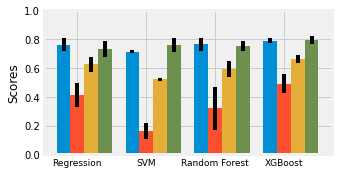

In [ ]:
X = 1.25 * np.arange(4) 
fig = plt.figure(figsize=(4,2))
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, np.mean(results[0], axis=1), yerr=np.std(results[0], axis=1), width = 0.25)
ax.bar(X + 0.25, np.mean(results[1], axis=1), yerr=np.std(results[1], axis=1),width = 0.25)
ax.bar(X + 0.50, np.mean(results[2], axis=1), yerr=np.std(results[2], axis=1),width = 0.25)
ax.bar(X + 0.75, np.mean(results[3], axis=1), yerr=np.std(results[3], axis=1),width = 0.25)
ax.set_ylabel('Scores')
# ax.set_title('XGBoost')
ax.set_xticks(X+0.25)
ax.set_xticklabels(('Regression', 'SVM', 'Random Forest', 'XGBoost'), fontdict={'size': 9})
# ax.set_yticks(np.arange(0, 1.0, 10))
ax.set_ylim([0, 1.0])
# ax.legend(labels=['acc', 'f-1', 'auc_1', 'auc_2'])
fig.savefig('all_results.png', bbox_inches='tight', pad_inches=0.2)
files.download('all_results.png')
plt.show()

In [ ]:
results[0]

array([[0.77, 0.7 , 0.81, 0.77, 0.7 , 0.81, 0.77, 0.7 , 0.81, 0.77, 0.7 ,
        0.81, 0.77, 0.7 , 0.81, 0.77, 0.7 , 0.81, 0.77, 0.7 , 0.81, 0.77,
        0.7 , 0.81, 0.77, 0.7 , 0.81, 0.77, 0.7 , 0.81, 0.77, 0.7 , 0.81,
        0.77, 0.7 , 0.81, 0.77, 0.7 , 0.81, 0.77, 0.7 , 0.81, 0.77, 0.7 ,
        0.81, 0.77, 0.7 , 0.81, 0.77, 0.7 , 0.81, 0.77, 0.7 , 0.81, 0.77,
        0.7 , 0.81, 0.77, 0.7 , 0.81, 0.77, 0.7 , 0.81, 0.77, 0.7 , 0.81,
        0.77, 0.7 , 0.81, 0.77, 0.7 , 0.81, 0.77, 0.7 , 0.81, 0.77, 0.7 ,
        0.81, 0.77, 0.7 , 0.81, 0.77, 0.7 , 0.81, 0.77, 0.7 , 0.81, 0.77,
        0.7 , 0.81, 0.77, 0.7 , 0.81, 0.77, 0.7 , 0.81, 0.77, 0.7 , 0.81,
        0.77],
       [0.72, 0.7 , 0.72, 0.72, 0.7 , 0.72, 0.72, 0.7 , 0.72, 0.72, 0.7 ,
        0.72, 0.72, 0.7 , 0.72, 0.72, 0.7 , 0.72, 0.72, 0.7 , 0.72, 0.72,
        0.7 , 0.72, 0.72, 0.7 , 0.72, 0.72, 0.7 , 0.72, 0.72, 0.7 , 0.72,
        0.72, 0.7 , 0.72, 0.72, 0.7 , 0.72, 0.72, 0.7 , 0.72, 0.72, 0.7 ,
        0.72, 0.72, 0.7

In [ ]:
print(np.mean(results[0], axis=1),
np.mean(results[1], axis=1),
np.mean(results[2], axis=1),
np.mean(results[3], axis=1))

[0.7601 0.7134 0.7631 0.7902] [0.4127 0.163  0.3182 0.4898] [0.6264 0.5199 0.5927 0.6599] [0.7328 0.7594 0.7502 0.7934]
